In [13]:
import networkx as nx
import osmnx as ox
import pickle
import folium
import requests
import json

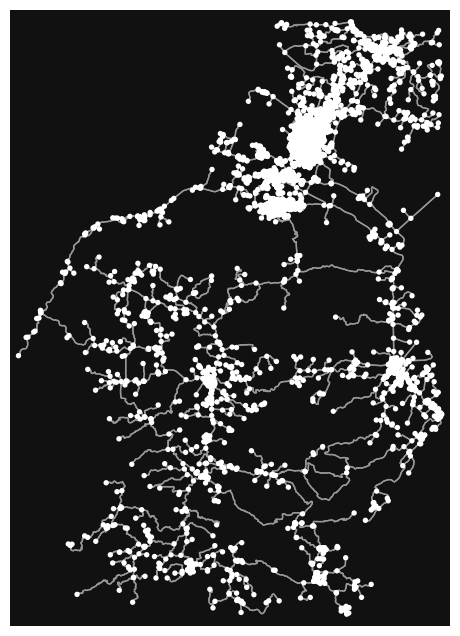

In [26]:

def get_bounding_box(query):
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": query,
        "format": "json",
        "limit": 1,
    }

    response = requests.get(url, params=params)
    result = response.json()
    return [float(coord) for coord in result[0]['boundingbox']]

bbox_norte = get_bounding_box("North Upi, Philippines")
bbox_sur = get_bounding_box("Datu Blah T. Sinsuat, Philippines")
bbox_south_upi = get_bounding_box("South Upi, Philippines")
bbox_datu_odin_sinsuat = get_bounding_box("Datu Odin Sinsuat, Philippines")
bbox_cotabato_city = get_bounding_box("Cotabato City, Philippines")

# Combine the bounding boxes
south = min(bbox_norte[0], bbox_sur[0], bbox_south_upi[0], bbox_datu_odin_sinsuat[0], bbox_cotabato_city[0])
north = max(bbox_norte[1], bbox_sur[1], bbox_south_upi[1], bbox_datu_odin_sinsuat[1], bbox_cotabato_city[1])
west = min(bbox_norte[2], bbox_sur[2], bbox_south_upi[2], bbox_datu_odin_sinsuat[2], bbox_cotabato_city[2])
east = max(bbox_norte[3], bbox_sur[3], bbox_south_upi[3], bbox_datu_odin_sinsuat[3], bbox_cotabato_city[3])

# Retrieve the road network for the combined bounding box
graph_2 = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Plot the road network
fig, ax = ox.plot_graph(graph_2)


In [27]:
end_point = (7.0198506, 124.1646850)
end_node = ox.distance.nearest_nodes(graph_2, X=[end_point[1]], Y=[end_point[0]])[0]

In [29]:
# Add a travel time attribute to the edges, assuming an average speed of 30 km/h
for u, v, data in graph_2.edges(data=True):
    data['travel_time'] = data['length'] / (30 * 1000 / 3600)  # Convert the average speed to m/s

stats = ox.stats.basic_stats(graph_2, area=None)

# Calculate the total travel time in seconds
total_travel_time = sum(data['travel_time'] for u, v, data in graph_2.edges(data=True))

# Calculate the average speed in km/h
avg_speed = (stats['edge_length_total'] / 1000) / (total_travel_time / 3600)

print(f"Average speed: {avg_speed:.2f} km/h")

# Find the nodes that are within the desired access time
desired_access_time = 60  # minutes
# avg_speed = 30  # km/h
nodes_within_time = {}
for node in graph_2.nodes():
    try:
        path_length = nx.shortest_path_length(graph_2, end_node, node, weight='length')
        travel_time = (path_length / 1000) / avg_speed * 60  # Convert to minutes
        if travel_time <= desired_access_time:
            nodes_within_time[node] = travel_time
    except nx.NetworkXNoPath:
        continue

# # Plot the graph, highlighting the nodes within the desired access time
# nc = ['red' if node in nodes_within_time else 'blue' for node in graph_2.nodes()]
# ox.plot_graph(graph_2, node_color=nc, node_zorder=3)

Average speed: 30.00 km/h


In [30]:
# Your previous code for adding the 'travel_time' attribute and finding nodes_within_time
# ...

# Load the map center from the pickle
with open('pickles/folium_center.pkl', 'rb') as f:
    map_center = pickle.load(f)

# Create the Folium map
overlay = folium.Map(location=map_center, zoom_start=8)

# Convert the graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph_2)

# Convert the edges GeoDataFrame to GeoJSON
edges_geojson = json.loads(edges.to_json())

# Create a GeoJson layer from the GeoJSON data
geojson_layer = folium.GeoJson(edges_geojson, name="Road Network")

# Add the GeoJson layer to the Folium map
geojson_layer.add_to(overlay)

# Add color-coded markers for the nodes
for node, data in nodes.iterrows():
    if node == end_node:
        color = 'purple'
        radius = 5  # Set the end_node size larger
    elif node in nodes_within_time:
        color = 'green'
        radius = 1
    else:
        color = 'red'
        radius = 1
    folium.CircleMarker(location=(data['y'], data['x']),
                        radius=radius,
                        color=color,
                        fill=True,
                        fill_color=color,
                        fill_opacity=0.7).add_to(overlay)

# Save the map to an HTML file
overlay.save('map_output_2.html')
# Show the map
# overlay
